# **Анализ твитов представителей американской киноиндустрии**

 <a id="1"></a> <br>
 # 1. Импорт нужных библиотек


In [2]:
import warnings
import sys
import os
import re

import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import networkx as nx
from PIL import Image
import seaborn as sns

from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.text import Text
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string 
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import Word2Vec


from wordcloud import WordCloud
from wordcloud import STOPWORDS
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

 <a id="2"></a> <br>
# 2. Загрузка данных и предварительный анализ

Загружаем датасет из трех тысяч ранее извлеченных и размеченных твитов

In [5]:
df = pd.read_csv("drive/MyDrive/colab/tweets2.csv")
df.drop(columns=['index'], inplace=True)
df.dropna(axis = 0, inplace = True)
df

,Username,Date,id,Preference,Tweet
0,ladygaga,2021-01-08 04:46:17+00:00,1.347404e+18,1.0,I hope we focus to impeach Trump so Congress h...
1,ladygaga,2020-11-17 20:00:59+00:00,1.328790e+18,1.0,"Just in time for the holidays, @hauslabs expan..."
2,ladygaga,2020-11-07 20:25:07+00:00,1.325172e+18,1.0,. @realDonaldTrump please concede. I know you...
3,ladygaga,2020-11-05 17:22:23+00:00,1.324402e+18,1.0,Make sure you take care of yourself while the ...
4,ladygaga,2020-11-03 01:01:08+00:00,1.323430e+18,1.0,.@realDonaldTrump #VoteBiden #Vote https://t.c...
...,...,...,...,...,...
3229,SachaBaronCohen,2020-03-19 15:36:37+00:00,1.240663e+18,1.0,"With coronavirus, lies and conspiracies will l..."
3230,SachaBaronCohen,2020-03-05 21:13:13+00:00,1.235675e+18,1.0,"Today, people spoke and Facebook backed down!\..."
3231,SachaBaronCohen,2019-08-26 03:23:19+00:00,1.165827e+18,1.0,"It says something about our time, that the man..."
3232,SachaBaronCohen,2019-07-16 16:24:52+00:00,1.151166e+18,0.0,Thank you to the EMMYs for the nominations\nfo...


- Republicans = 0
- Democrats = 1

In [6]:
df.Preference.value_counts()

1.0    1692
0.0    1542
Name: Preference, dtype: int64

Имеем в целом сбалансированную по партиям выборку

 <a id="21"></a> <br>
### 2.1 Смотрим на самые популярные хэштеги для каждого класса

In [7]:
def extract_hashtags(tweet):
        hashtag = re.findall('(\#[A-Za-z_]+)', tweet)
        if hashtag:
            return hashtag
        return ""

In [8]:
df_hashtags = df.copy()
df_hashtags['top_hashtags'] = df_hashtags['Tweet'].apply(lambda x: extract_hashtags(x))

hashtags_democrats = []
hashtags_republicans = []

for i in range(len(df_hashtags['top_hashtags'])):
    if df_hashtags['Preference'][i] == 0:
        hashtags_republicans += df_hashtags['top_hashtags'][i]
    elif df_hashtags['Preference'][i] == 1:
        hashtags_democrats += df_hashtags['top_hashtags'][i]

Text(0.5, 1.0, '5 most used hashtags in democrat tweets')

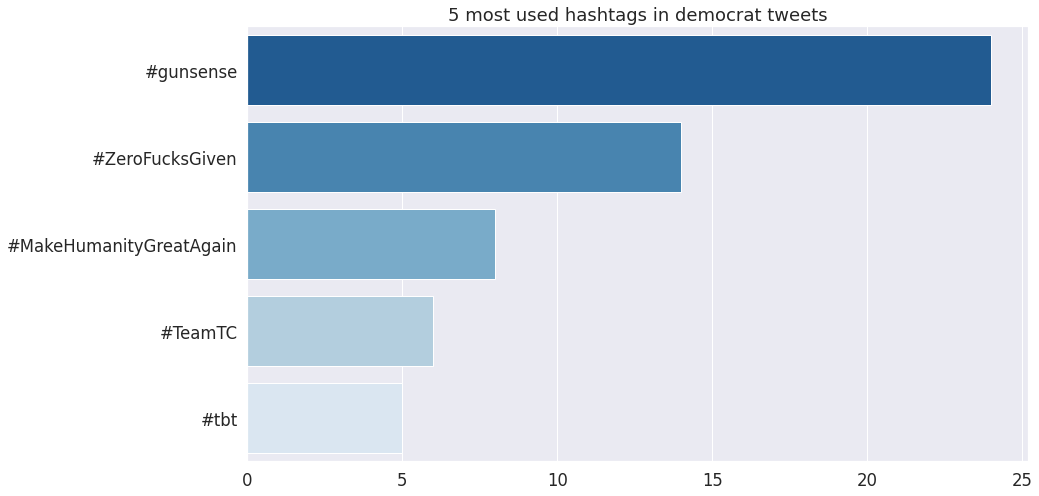

In [9]:
dem_top_hashtags = Series(hashtags_democrats).value_counts().head(n=5)
sns.set_style("white")
sns.set(font_scale=1.5)
plt.figure(figsize=(14,8))
sns.barplot(x=dem_top_hashtags, y=dem_top_hashtags.index,  orient='h', palette="Blues_r").set_title("5 most used hashtags in democrat tweets")

Text(0.5, 1.0, '5 most used hashtags in republican tweets')

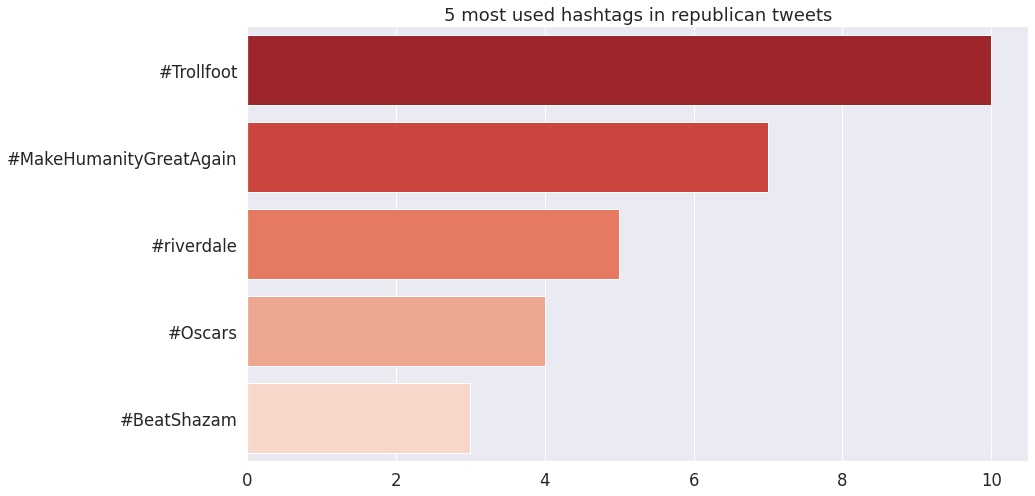

In [10]:
rep_top_hashtags = Series(hashtags_republicans).value_counts().head(n=5)
sns.set_style("white")
sns.set(font_scale=1.5)
plt.figure(figsize=(14, 8))
sns.barplot(x=rep_top_hashtags, y=rep_top_hashtags.index, orient='h', palette="Reds_r").set_title("5 most used hashtags in republican tweets")

Самый популярный хэштег в либеральных твитах -- #gunsense, посвященный проблеме свободного оборота оружия. Все остальные хэштеги не имеют политической подоплёки и связаны с раазличными развлекательными событиями. При этом стоит отметить, что хэштег MakeHumanityGreatAgain упоминается в твитах обоих классов, несмотря на то, что является пародией на известный слоган республиканцев Make America Great Again

 <a id="3"></a> <br>
# 3. Очистка данных и продолжение первичного анализа данных

Удалим всякий мусор типа @, #, https, RT и так далее. Избавимся от слов-мусора, которые не дают ценной информации. Проведем лемматизацию слов.

Используем stopwords из библиотеки wordcloud

In [11]:
republican = df[df.Preference == 0]
democrat = df[df.Preference == 1]

In [12]:
STOPWORDS.add("amp")
STOPWORDS.add("rt")
STOPWORDS.add("s")
STOPWORDS.add("u")
STOPWORDS.add("th")
STOPWORDS.add("will")
STOPWORDS.add("t")
STOPWORDS.add("re")
STOPWORDS.add("m")
STOPWORDS.add('",')

In [13]:
# Сначала пройдемся по твитам демократов
democrat_list = []
for tweet in democrat.Tweet:
    tweet = re.sub(r'http\S+', '', tweet)  # удалим ссылки
    tweet = re.sub("[^a-zA-Z]", " ", tweet)  # оставим только буквы
    tweet = tweet.lower()  # приведем все к нижнему регистру
    tweet = nltk.word_tokenize(tweet)  # разбить предложение на слова
    tweet = [word for word in tweet if not word in STOPWORDS]  # удалить stopwords
    lemma = nltk.WordNetLemmatizer() 
    tweet = [lemma.lemmatize(word) for word in tweet]  # лемматизация
    tweet = " ".join(tweet)
    democrat_list.append(tweet)  # получили новый твит и теперь сохраняем его

In [15]:
# Теперь аналогично для твитов республиканцев
republican_list = []
for tweet in republican.Tweet:
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub("[^a-zA-Z]", " ", tweet) 
    tweet = tweet.lower()
    tweet = nltk.word_tokenize(tweet)
    tweet = [word for word in tweet if not word in STOPWORDS]
    lemma = nltk.WordNetLemmatizer() 
    tweet = [lemma.lemmatize(word) for word in tweet] 
    tweet = " ".join(tweet)
    republican_list.append(tweet)

Посмотрим, что получилось

In [16]:
# Первые 10 получившихся твитов демократов
democrat_list[:10]

['hope focus impeach trump congress constitutional authority possibly disqualify future election thamendment doesn disqualify incited domestic terror much violence need happen terrorism',
 'time holiday hauslabs expanded dream matte lip formula new shade le monster matte lip crayon holiday hope spread color kindness',
 'realdonaldtrump please concede know see america suffered election fought presidency year please part peaceful transition power transition peaceful election',
 'make sure take care election vote continue counted sleep rest important',
 'realdonaldtrump votebiden vote',
 'hey tim hey realdonaldtrump happy im glad living rent free head bidenharris',
 'must vote voting essential debate',
 'want stage performing fan super virus vmas',
 'show set exclusive dj mix bloodpop burnsmusic vitaclub iamtchami',
 'togetherathome glblctzn']

In [17]:
# Первые 10 поучившихся твитов республиканцев
republican_list[:10]

['omg charity btwfoundation book today called channelkindness filled beautiful story bravery power kindness importance mental health love enjoy masterpiece made young people people',
 'love tony',
 'short film minute',
 'want relive music click stream performance',
 'overwhelmed joy work star born continues recognized year released thank recordingacad grammy nomination today',
 'vega mood',
 'astarisborn spotify',
 'astarisborn spotify',
 'heart soundtrack star born',
 'happy birthday manager best friend bobby campbell love moon back thank taking good care']

Теперь обособленно посмотрим на слова в твитах

In [18]:
def words_from_tweets(tweets):
    words = []
    for word in tweets:
        words.append(word.replace("'", ""))
        words.append(word.replace("[", ""))
        words.append(word.replace("]", ""))
        words.append(word.replace(",", ""))
        words.append(word.replace('"', ""))
        words.append(word.replace("'", ""))
    return words

democrat_tweets = str(democrat_list).split()
democrat_tweets = words_from_tweets(democrat_tweets)

republican_tweets = str(republican_list).split()
republican_tweets = words_from_tweets(republican_tweets)

Суммарное количество слов в твитах

In [19]:
print("Суммарное количество слов в твитах демократов:", len(democrat_tweets))
print("Суммарное количество слов в твитах республиканцев:", len(republican_tweets))

Суммарное количество слов в твитах демократов: 100902
Суммарное количество слов в твитах республиканцев: 65160


 <a id="3.1"></a> <br>
###  Частота использования слов

In [20]:
# Частоты каждого слова по партиям
freqdist_democrat = FreqDist(democrat_tweets)
freqdist_republican = FreqDist(republican_tweets)

In [25]:
dem_freq = Series(freqdist_democrat).sort_values(ascending=False).head(10)
rep_freq = Series(freqdist_republican).sort_values(ascending=False).iloc[[0,1,2,4,5,6,7,8,9,10]]

Text(0.5, 1.0, '10 most used words in democrat tweets')

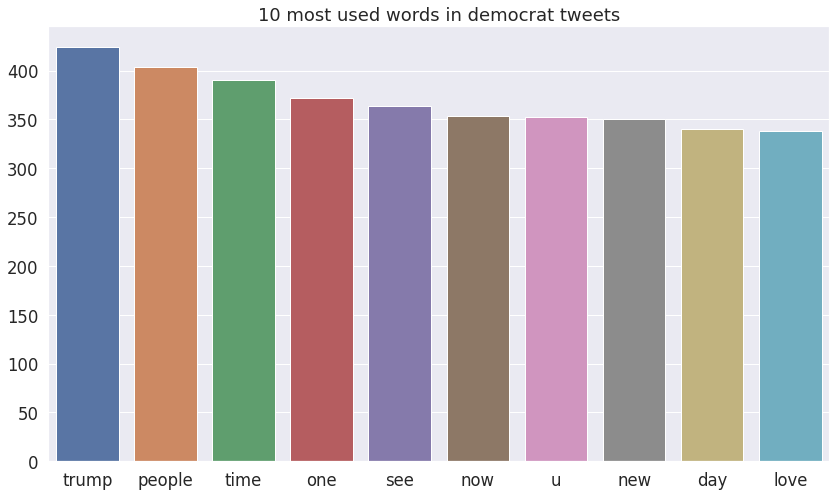

In [26]:
sns.set_style("white")
sns.set(font_scale=1.5)
plt.figure(figsize=(14, 8))
sns.barplot(x=dem_freq.index, y=dem_freq).set_title("10 most used words in democrat tweets")

Text(0.5, 1.0, '10 most used words in republican tweets')

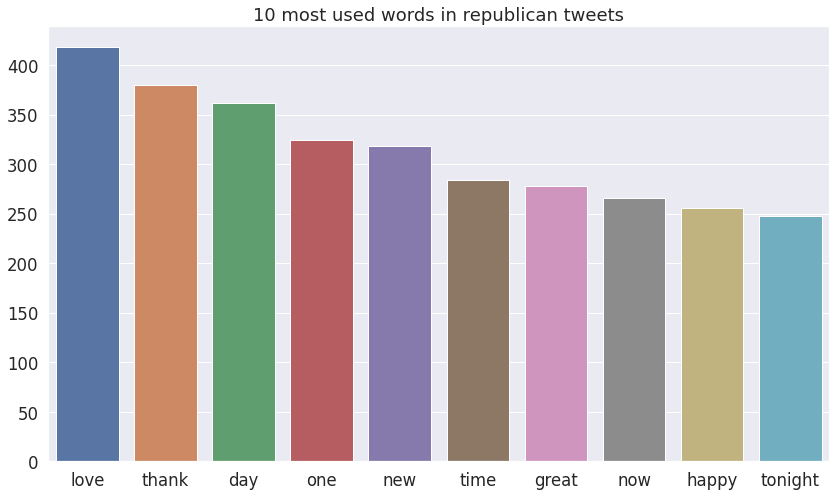

In [27]:
sns.set_style("white")
sns.set(font_scale=1.5)
plt.figure(figsize=(14, 8))
sns.barplot(x=rep_freq.index, y=rep_freq).set_title("10 most used words in republican tweets")

Самое часто встречаемое слово в твитах демократов - фамилия бывшего президента республиканца Дональда Трампа. В твитах республиканцев -- love. Стоит заметить, что за исключением Трампа, политические термины явно не употребляются

Объединим частоты в одну табличку...

In [28]:
de = pd.DataFrame(list(freqdist_democrat.items()), columns = ["word", "democrat frequency"])
re = pd.DataFrame(list(freqdist_republican.items()), columns = ["word", "republican frequency"])
w_freq_together = pd.merge(de, re, on='word')
w_freq_together.head()

,word,democrat frequency,republican frequency
0,focus,26,18
1,trump,424,48
2,future,74,6
3,election,98,6
4,doesn,116,12


... и сравним употребление слов, часто упоминаемых в политическом контексте (trump/election/vote/biden/usa)

In [29]:
w_freq_together[(w_freq_together.word == "trump") | (w_freq_together.word == "vote") | (w_freq_together.word == "election") | (w_freq_together.word == "biden") | (w_freq_together.word == "usa")]

,word,democrat frequency,republican frequency
1,trump,424,48
3,election,98,6
39,vote,182,102
1497,biden,30,42
2121,usa,24,12


Примечательно, что демократы сильно чаще республиканцев говорят о Трампе, а республиканцы чуть чаще демократов говорят о Байдене. Так же судя по таблице можно предположить, что демократы чаще республиканцев зазывают аудиторию соцсети на выборы

 <a id="42"></a> <br>
### Распределение слов по тексту

Рассмотрим распределение следующих слов: vote, trump, biden, democracy, freedom, america, election, tax

 <a id="51"></a> <br>
### Распределение слов у демократов

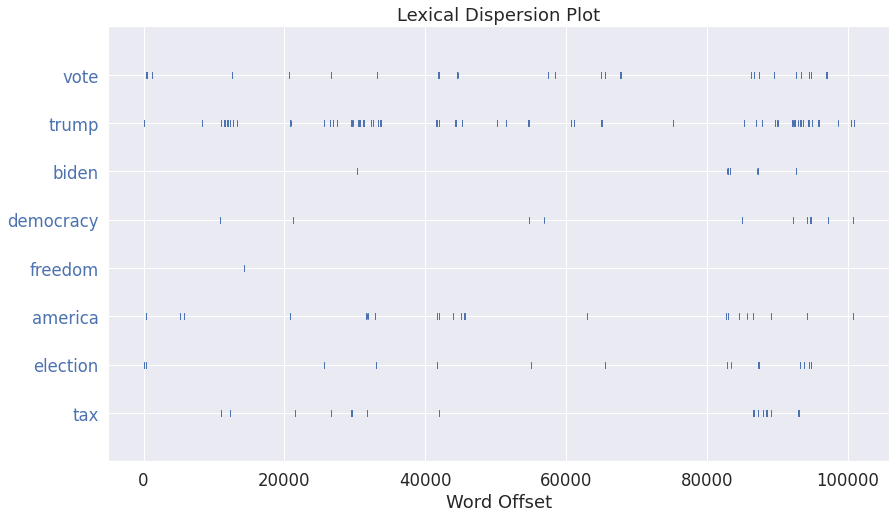

In [30]:
plt.subplots(figsize=(14, 8))
democrat_tweet = Text(democrat_tweets)
democrat_tweet.dispersion_plot(["vote", "trump", "biden", "democracy", "freedom", "america", "election", "tax"])

 <a id="52"></a> <br>
### Распределение слов у республиканцев

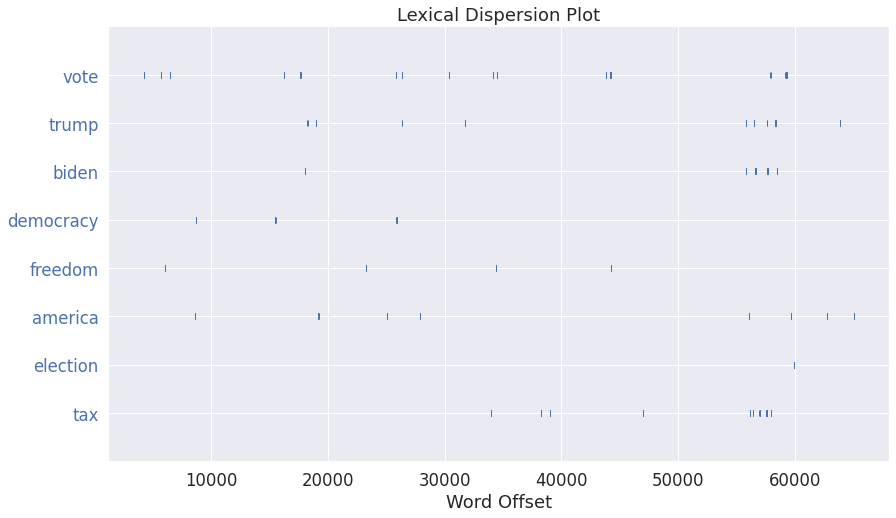

In [31]:
plt.subplots(figsize=(14, 8))
republican_tweet = Text(republican_tweets)
republican_tweet.dispersion_plot(["vote", "trump", "biden", "democracy", "freedom", "america", "election", "tax"])

### Базовый сентиментальный анализ


Значение параметра **polarity**, число в диапазоне [-1.0, 1.0], характеризует эмоциональную окраску текста. Здесь **1** означает позитивное высказывание и **-1** означает негативное высказывание.

Значение параметра **subjectivity**, число в диапазоне [0.0, 1.0], характеризует субъективность высказывания. Здесь **0.0** означает объективность высказывания, а **1.0** означает субъективное высказывание

In [32]:
democrat_blob = TextBlob(str(democrat_tweets))
democrat_blob.sentiment

Sentiment(polarity=0.1820393884612979, subjectivity=0.5429135618576302)

In [33]:
republican_blob = TextBlob(str(republican_tweets))
republican_blob.sentiment

Sentiment(polarity=0.2661933803679356, subjectivity=0.5551262337121604)

Из полученных результатов можно сделать вывод, что республиканцы более позитивны, и самую малость более склонны к субъективности в своих высказываниях

# 4. Обучение моделей

In [34]:
# Разделим как обычно на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.3, random_state=69)
train.shape, test.shape

((2263, 5), (971, 5))

In [35]:
train.head()

,Username,Date,id,Preference,Tweet
2606,ChloeGMoretz,2017-06-09 08:24:39+00:00,8.730935e+17,1.0,Damn damn. @PURITY_RING you guys killed it mak...
816,SarahKSilverman,2020-12-27 01:31:03+00:00,1.343006e+18,0.0,@hollywood_labor @GhostPanther Yes credit unio...
2120,DannyDeVito,2015-11-03 10:22:00+00:00,6.614885e+17,1.0,#Trollfoot waiting his turn to Tango @nespress...
2758,GalGadot,2016-10-19 15:03:43+00:00,7.887575e+17,1.0,Watch Dr. Ruth &amp; Dr. Drew couple up for #K...
1349,MarkRuffalo,2020-12-05 00:45:40+00:00,1.335022e+18,1.0,Let’s #ShowUpForGeorgia! I’m all in to take ba...


In [36]:
train['Preference'].value_counts()

1.0    1190
0.0    1073
Name: Preference, dtype: int64

In [37]:
st = LancasterStemmer()

def token(text):
    txt = nltk.word_tokenize(text.lower())
    return [st.stem(word) for word in txt]

## 4.1 CountVectorizer

Используем CountVectorizer для получения признаков

In [38]:
cv = CountVectorizer(lowercase=True, tokenizer=token, stop_words=STOPWORDS, analyzer=u'word', min_df=4)

In [39]:
vec_train = cv.fit_transform(train['Tweet'].tolist())
vec_test = cv.transform(test['Tweet'].tolist())

In [95]:
vec_train

<2263x1061 sparse matrix of type '<class 'numpy.int64'>'
	with 22391 stored elements in Compressed Sparse Row format>

### 4.1.1 DecisionTreeClassifier

Best max_depth: 5


Text(0.5, 1.0, 'CV score for different max_depths')

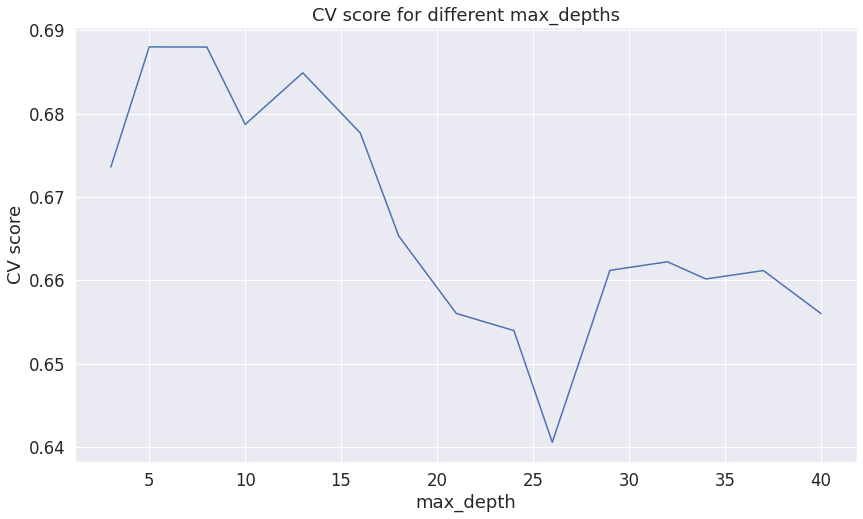

In [40]:
max_depths = np.linspace(3, 40, 15, dtype=int)
dtc = DecisionTreeClassifier()
searcher = GridSearchCV(dtc, [{"max_depth": max_depths}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_max_depth_dt = searcher.best_params_["max_depth"]
print('Best max_depth:', best_max_depth_dt)

plt.figure(figsize=(14, 8))
plt.plot(max_depths, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("CV score")
plt.title("CV score for different max_depths")

Best min_samples_split: 10


Text(0.5, 1.0, 'CV score for different min_samples_splits')

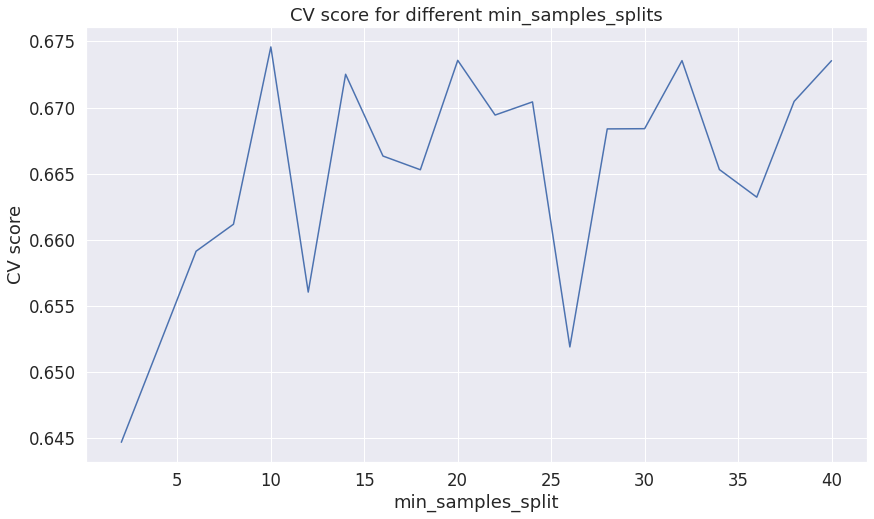

In [41]:
min_samples_splits = np.linspace(2, 40, 20, dtype=int)
dtc = DecisionTreeClassifier()
searcher = GridSearchCV(dtc, [{"min_samples_split": min_samples_splits}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_min_samples_split_dt = searcher.best_params_["min_samples_split"]
print('Best min_samples_split:', best_min_samples_split_dt)

plt.figure(figsize=(14, 8))
plt.plot(min_samples_splits, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.title("CV score for different min_samples_splits")

In [42]:
dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(vec_train.toarray(), train['Preference'])

y_pred_dtc = dtc.predict(vec_test.toarray())
print('Default DecisionTreeClassifier accuracy:', accuracy_score(y_pred_dtc, test['Preference']))

Default DecisionTreeClassifier accuracy: 0.650875386199794


In [43]:
best_dtc = DecisionTreeClassifier(max_depth=best_max_depth_dt, min_samples_split=best_min_samples_split_dt, random_state = 42)
best_dtc.fit(vec_train.toarray(), train['Preference'])

y_pred_best_dtc = best_dtc.predict(vec_test.toarray())
print('Optimized DecisionTreeClassifier accuracy:', accuracy_score(y_pred_best_dtc, test['Preference']))

Optimized DecisionTreeClassifier accuracy: 0.6519052523171988


### 4.1.2 RandomForestClassifier

Best max_depth value 32


Text(0.5, 1.0, 'CV score for different max_depths')

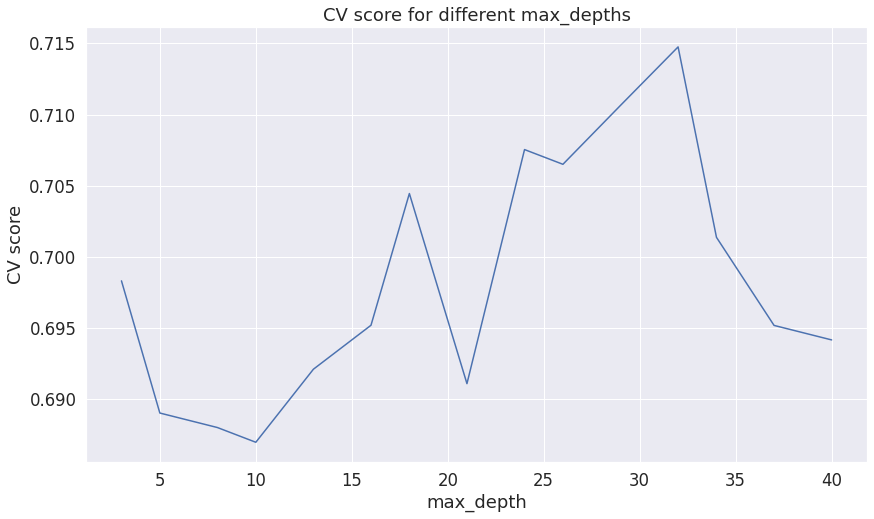

In [44]:
max_depths = np.linspace(3, 40, 15, dtype=int)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
searcher = GridSearchCV(rfc, [{"max_depth": max_depths}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_max_depth = searcher.best_params_["max_depth"]
print('Best max_depth value', best_max_depth)

plt.figure(figsize=(14, 8))
plt.plot(max_depths, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("CV score")
plt.title("CV score for different max_depths")

Best min_samples_split 34


Text(0.5, 1.0, 'CV score for different min_samples_splits')

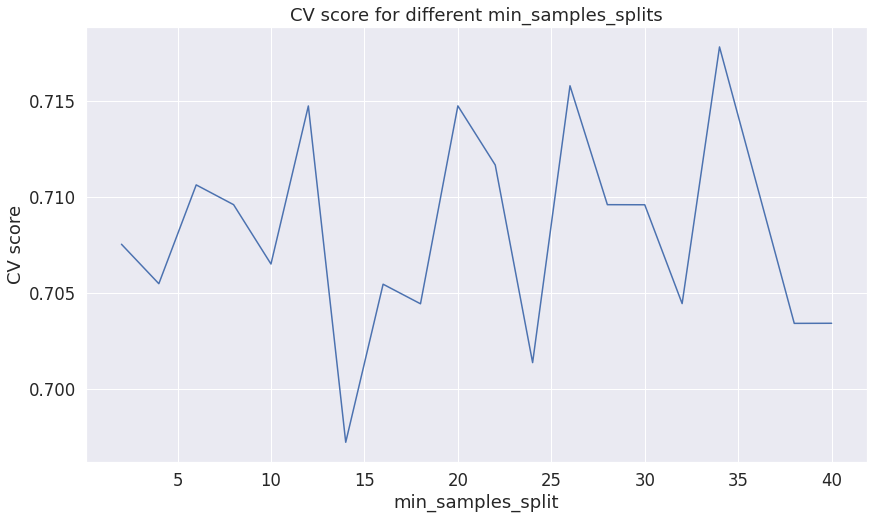

In [45]:
min_samples_splits = np.linspace(2, 40, 20, dtype=int)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
searcher = GridSearchCV(rfc, [{"min_samples_split": min_samples_splits}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_min_samples_split = searcher.best_params_["min_samples_split"]
print('Best min_samples_split', best_min_samples_split)

plt.figure(figsize=(14, 8))
plt.plot(min_samples_splits, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.title("CV score for different min_samples_splits")

In [46]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X = vec_train, y = train['Preference'])

y_pred_rfc = rfc.predict(vec_test)
print('Default RandomForestClassifier accuracy:', accuracy_score(y_pred_rfc, test['Preference']))

Default RandomForestClassifier accuracy: 0.7157569515962925


In [47]:
best_rfc = RandomForestClassifier(n_estimators=100, max_depth=best_max_depth, min_samples_split=best_min_samples_split, n_jobs=-1)
best_rfc.fit(X = vec_train, y = train['Preference'])

y_pred_best_rfc = best_rfc.predict(vec_test)
print('Optimized RandomForestClassifier accuracy:', accuracy_score(y_pred_best_rfc, test['Preference']))

Optimized RandomForestClassifier accuracy: 0.7270854788877446


### 4.1.3 LogisticRegression

Best regularization parameter: 0.5179474679231213


Text(0.5, 1.0, 'CV score for different C')

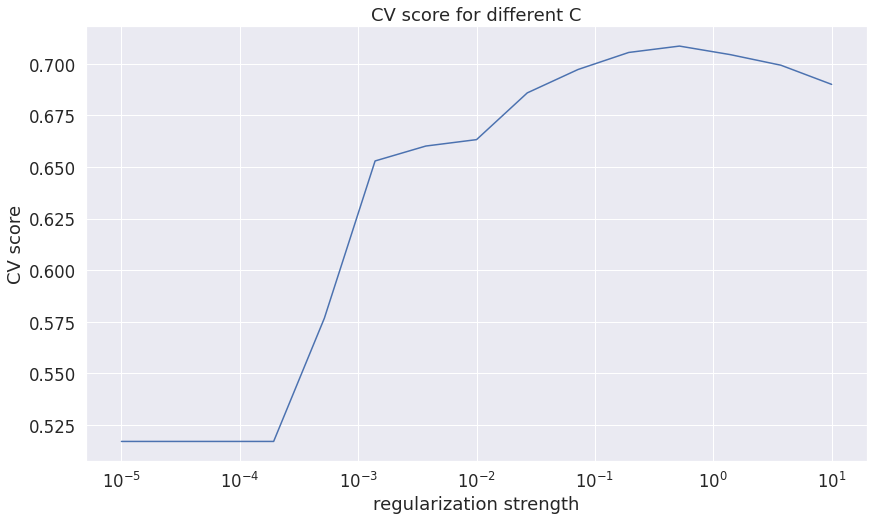

In [48]:
C_reg = np.logspace(-5, 1, 15)
lr = LogisticRegression()
searcher = GridSearchCV(lr, [{"C": C_reg}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_C = searcher.best_params_["C"]
print('Best regularization parameter:', best_C)

plt.figure(figsize=(14, 8))
plt.plot(C_reg, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("regularization strength")
plt.ylabel("CV score")
plt.title("CV score for different C")

Best solver: sag


Text(0.5, 1.0, 'CV score for different solvers')

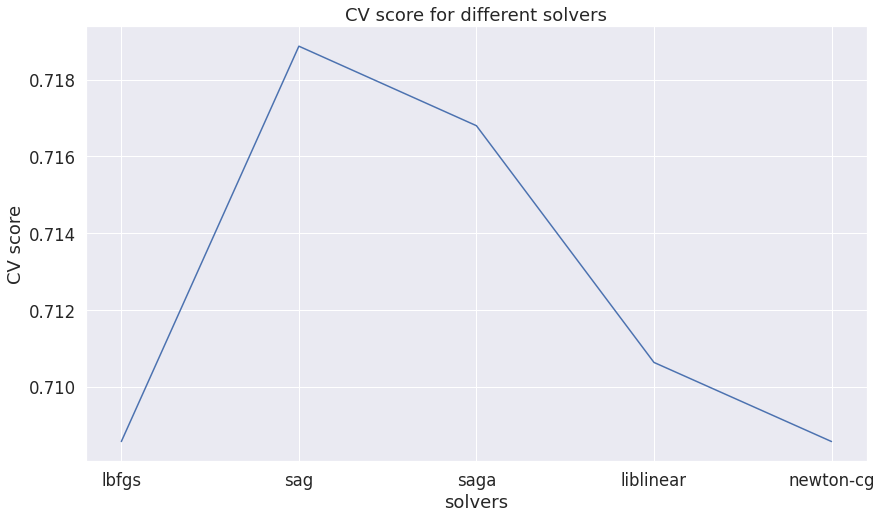

In [49]:
solvers = ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg']
lr = LogisticRegression()
searcher = GridSearchCV(lr, [{"solver": solvers}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_solver = searcher.best_params_["solver"]
print('Best solver:', best_solver)

plt.figure(figsize=(14, 8))
plt.plot(solvers, searcher.cv_results_["mean_test_score"])
#plt.xscale("log")
plt.xlabel("solvers")
plt.ylabel("CV score")
plt.title("CV score for different solvers")

In [50]:
lr = LogisticRegression()
lr.fit(X = vec_train, y = train['Preference'])

y_pred_lr = lr.predict(vec_test)
print('Default LogisticRegression accuracy:', accuracy_score(y_pred_lr, test['Preference']))

Default LogisticRegression accuracy: 0.7384140061791967


In [51]:
best_lr = LogisticRegression(C=best_C, solver=best_solver)
best_lr.fit(X = vec_train, y = train['Preference'])

y_pred_best_lr = best_lr.predict(vec_test)
print('Optimized LogisticRegression accuracy:', accuracy_score(y_pred_best_lr, test['Preference']))

Optimized LogisticRegression accuracy: 0.7476828012358393


### 4.1.4 MultinomialNB

Best alpha: 0.5179474679231213


Text(0.5, 1.0, 'CV score for different alphas')

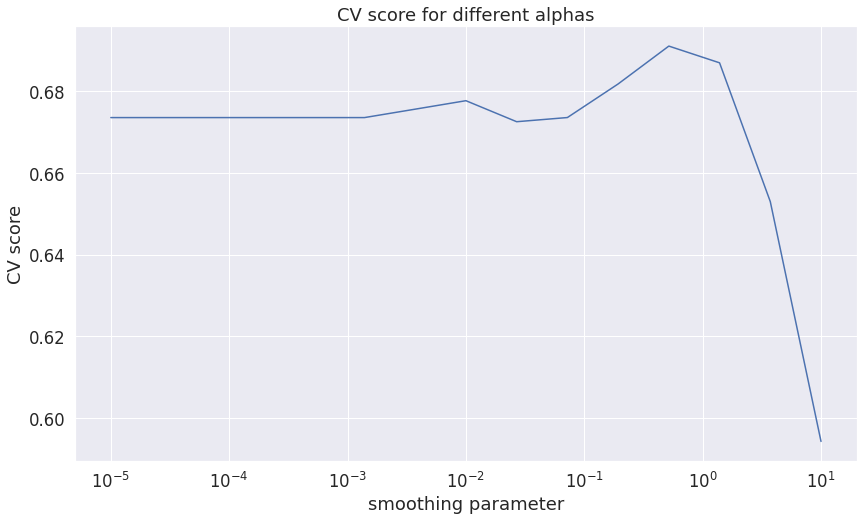

In [52]:
alphas = np.logspace(-5, 1, 15)
mnb = MultinomialNB()
searcher = GridSearchCV(mnb, [{"alpha": alphas}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_alpha = searcher.best_params_["alpha"]
print('Best alpha:', best_alpha)

plt.figure(figsize=(14, 8))
plt.plot(alphas, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("smoothing parameter")
plt.ylabel("CV score")
plt.title("CV score for different alphas")

In [53]:
mnb = MultinomialNB()
mnb.fit(vec_train.toarray(), train['Preference'])

y_pred_mnb = mnb.predict(vec_test.toarray())
print('Default MultinomialNB accuracy:', accuracy_score(y_pred_mnb, test['Preference']))

Default MultinomialNB accuracy: 0.7188465499485067


In [54]:
best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(vec_train.toarray(), train['Preference'])

y_pred_best_mnb = best_mnb.predict(vec_test.toarray())
print('Optimized MultinomialNB accuracy:', accuracy_score(y_pred_best_mnb, test['Preference']))

Optimized MultinomialNB accuracy: 0.7250257466529351


### 4.1.5 AdaBoostClassifier

In [55]:
ac = AdaBoostClassifier(n_estimators = 100)
ac.fit(vec_train.toarray(), train['Preference'])

y_pred_ac = ac.predict(vec_test.toarray())
print('Default AdaBoostClassifier accuracy:', accuracy_score(y_pred_ac, test['Preference']))

Default AdaBoostClassifier accuracy: 0.7075180226570545


### 4.1.6 LightGBM

In [56]:
!pip install optuna

     |████████████████████████████████| 296kB 5.3MB/s 
     |████████████████████████████████| 174kB 9.5MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 112kB 9.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 143kB 8.0MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=2dae2ca1b1f0be31a3904a2412b026172e62f9977140c7d9734090388d88c767
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [57]:
import optuna
import lightgbm as lgb

In [58]:
def objective(trial):
    # X_train, X_valid, y_train, y_valid = train_test_split(vec_train.toarray(), tra, test_size=0.25)
    X_train, X_valid, y_train, y_valid = vec_train.toarray(), vec_test.toarray(), train['Preference'], test['Preference']
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        'random_state' : 42,
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
    )

    preds = gbm.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy


study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
)
study.optimize(objective, n_trials=1000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-06-05 09:25:58,330] A new study created in memory with name: no-name-dc3ded07-d0ca-4a19-837f-591bd4445292
[I 2021-06-05 09:25:58,760] Trial 0 finished with value: 0.6725025746652935 and parameters: {'n_estimators': 176, 'max_depth': 25, 'learning_rate': 0.630949801089159}. Best is trial 0 with value: 0.6725025746652935.
[I 2021-06-05 09:25:58,925] Trial 1 finished with value: 0.6992790937178167 and parameters: {'n_estimators': 56, 'max_depth': 27, 'learning_rate': 0.13153774230505827}. Best is trial 1 with value: 0.6992790937178167.
[I 2021-06-05 09:25:59,290] Trial 2 finished with value: 0.694129763130793 and parameters: {'n_estimators': 194, 'max_depth': 15, 'learning_rate': 0.2249727593456778}. Best is trial 1 with value: 0.6992790937178167.
[I 2021-06-05 09:25:59,405] Trial 3 finished with value: 0.6683831101956745 and parameters: {'n_estimators': 34, 'max_depth': 25, 'learning_rate': 0.9857959453914744}. Best is trial 1 with value: 0.6992790937178167.
[I 2021-06-05 09:25:5

Number of finished trials: 1000
Best trial:
  Value: 0.7281153450051493
  Params: 
    n_estimators: 17
    max_depth: 28
    learning_rate: 0.4381017974279134


### 4.1.7 Сравнение результатов

In [62]:
predictions = [y_pred_dtc, y_pred_best_dtc, y_pred_rfc, y_pred_best_rfc, y_pred_lr, y_pred_best_lr, y_pred_mnb, y_pred_best_mnb, y_pred_ac]
accuracy_scores = [accuracy_score(pred, test['Preference']) for pred in predictions]
accuracy_scores.append(trial.value)

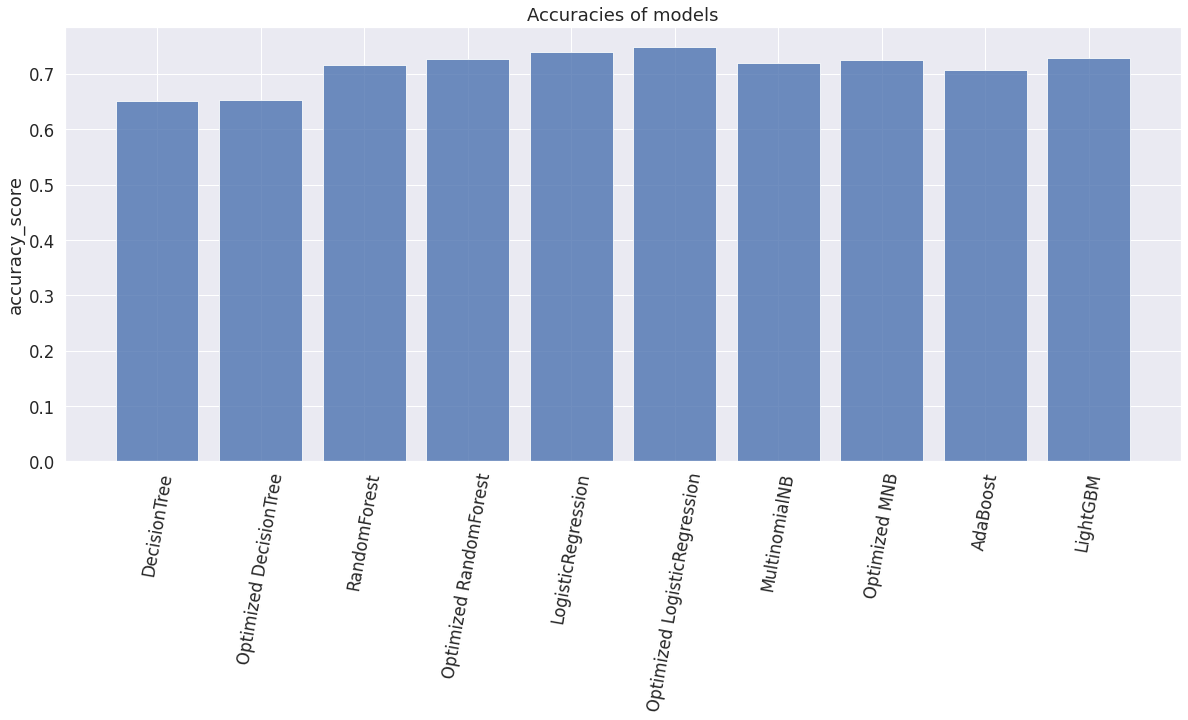

In [71]:
classifiers = ['DecisionTree', 'Optimized DecisionTree', 'RandomForest', 'Optimized RandomForest', 'LogisticRegression', 'Optimized LogisticRegression', 'MultinomialNB', 'Optimized MNB', 'AdaBoost', 'LightGBM']

Y_pos = np.arange(len(classifiers))
plt.figure(figsize=(20, 8))
plt.bar(Y_pos, accuracy_scores, align='center', alpha=0.8)
plt.xticks(Y_pos, classifiers, rotation=80)
plt.ylabel('accuracy_score')
plt.title('Accuracies of models')
plt.show()

## 4.2 TfidfVectorizer
Используем TfidfVectorizer для получения признаков

In [102]:
tv = TfidfVectorizer(lowercase=True, tokenizer=token, stop_words = STOPWORDS, analyzer=u'word', min_df=4)

In [103]:
vec_train = tv.fit_transform(train['Tweet'].tolist())
vec_test = tv.transform(test['Tweet'].tolist())

In [104]:
vec_train

<2263x1061 sparse matrix of type '<class 'numpy.float64'>'
	with 22391 stored elements in Compressed Sparse Row format>

### 4.2.1 DecisionTreeClassifier

Best max_depth: 8


Text(0.5, 1.0, 'CV score for different max_depths')

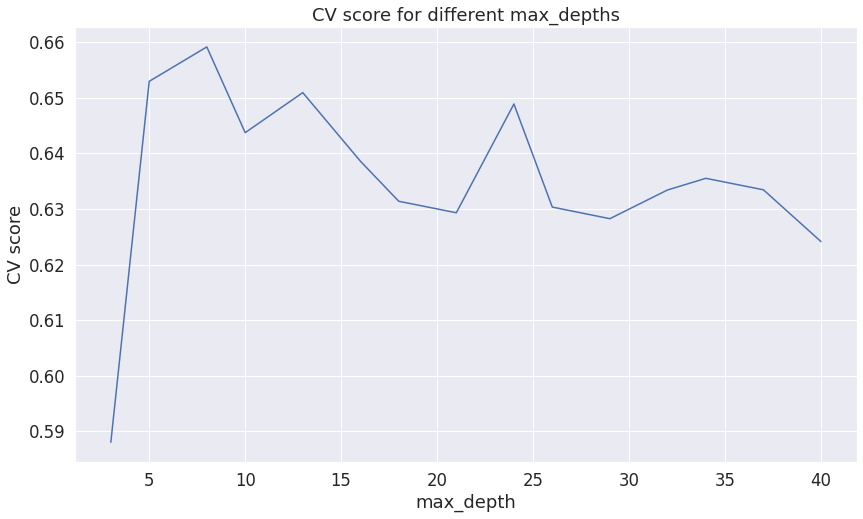

In [105]:
max_depths = np.linspace(3, 40, 15, dtype=int)
dtc = DecisionTreeClassifier()
searcher = GridSearchCV(dtc, [{"max_depth": max_depths}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_max_depth_dt = searcher.best_params_["max_depth"]
print('Best max_depth:', best_max_depth_dt)

plt.figure(figsize=(14, 8))
plt.plot(max_depths, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("CV score")
plt.title("CV score for different max_depths")

Best min_samples_split: 34


Text(0.5, 1.0, 'CV score for different min_samples_splits')

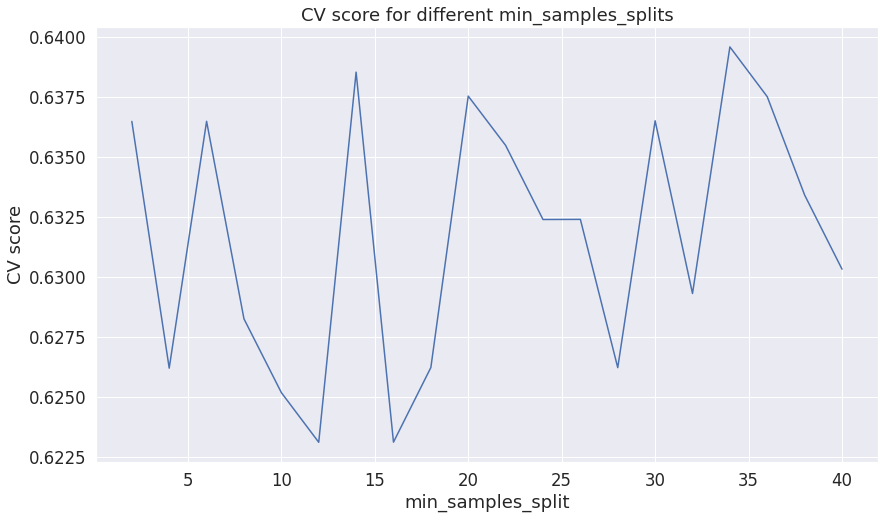

In [106]:
min_samples_splits = np.linspace(2, 40, 20, dtype=int)
dtc = DecisionTreeClassifier()
searcher = GridSearchCV(dtc, [{"min_samples_split": min_samples_splits}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_min_samples_split_dt = searcher.best_params_["min_samples_split"]
print('Best min_samples_split:', best_min_samples_split_dt)

plt.figure(figsize=(14, 8))
plt.plot(min_samples_splits, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.title("CV score for different min_samples_splits")

In [107]:
dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(vec_train.toarray(), train['Preference'])

y_pred_dtc = dtc.predict(vec_test.toarray())
print('Default DecisionTreeClassifier accuracy:', accuracy_score(y_pred_dtc, test['Preference']))

Default DecisionTreeClassifier accuracy: 0.6302780638516993


In [108]:
best_dtc = DecisionTreeClassifier(max_depth=best_max_depth_dt, min_samples_split=best_min_samples_split_dt, random_state = 42)
best_dtc.fit(vec_train.toarray(), train['Preference'])

y_pred_best_dtc = best_dtc.predict(vec_test.toarray())
print('Optimized DecisionTreeClassifier accuracy:', accuracy_score(y_pred_best_dtc, test['Preference']))

Optimized DecisionTreeClassifier accuracy: 0.6529351184346035


### 4.2.2 RandomForestClassifier

Best max_depth value 32


Text(0.5, 1.0, 'CV score for different max_depths')

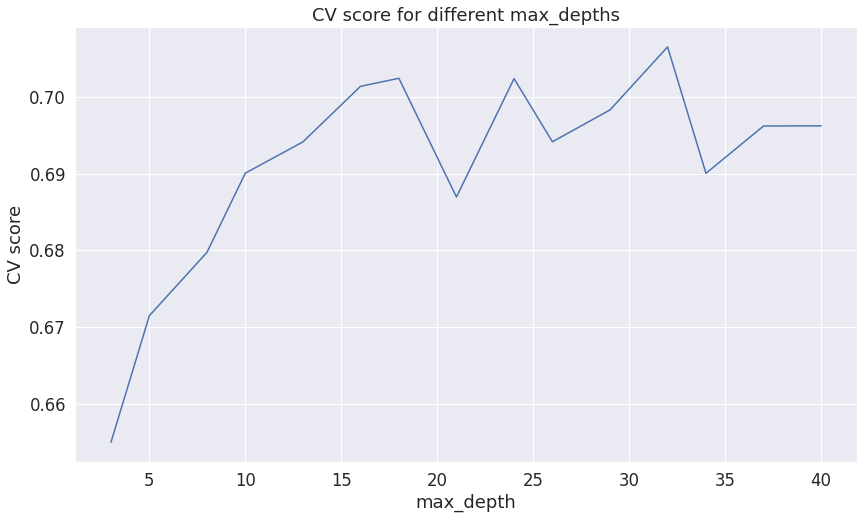

In [109]:
max_depths = np.linspace(3, 40, 15, dtype=int)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
searcher = GridSearchCV(rfc, [{"max_depth": max_depths}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_max_depth = searcher.best_params_["max_depth"]
print('Best max_depth value', best_max_depth)

plt.figure(figsize=(14, 8))
plt.plot(max_depths, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("CV score")
plt.title("CV score for different max_depths")

Best min_samples_split 20


Text(0.5, 1.0, 'CV score for different min_samples_splits')

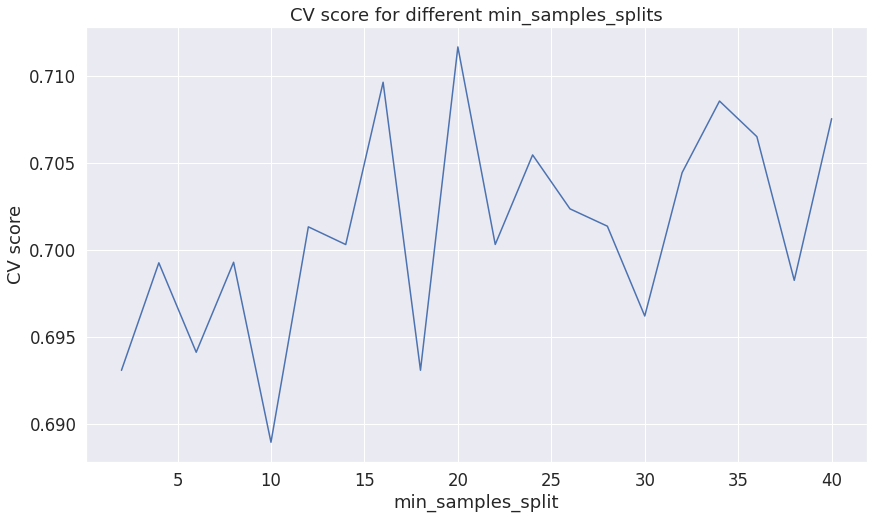

In [110]:
min_samples_splits = np.linspace(2, 40, 20, dtype=int)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
searcher = GridSearchCV(rfc, [{"min_samples_split": min_samples_splits}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_min_samples_split = searcher.best_params_["min_samples_split"]
print('Best min_samples_split', best_min_samples_split)

plt.figure(figsize=(14, 8))
plt.plot(min_samples_splits, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
plt.xlabel("min_samples_split")
plt.ylabel("CV score")
plt.title("CV score for different min_samples_splits")

In [111]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X = vec_train, y = train['Preference'])

y_pred_rfc = rfc.predict(vec_test)
print('Default RandomForestClassifier accuracy:', accuracy_score(y_pred_rfc, test['Preference']))

Default RandomForestClassifier accuracy: 0.7260556127703398


In [112]:
best_rfc = RandomForestClassifier(n_estimators=100, max_depth=best_max_depth, min_samples_split=best_min_samples_split, n_jobs=-1)
best_rfc.fit(X = vec_train, y = train['Preference'])

y_pred_best_rfc = best_rfc.predict(vec_test)
print('Optimized RandomForestClassifier accuracy:', accuracy_score(y_pred_best_rfc, test['Preference']))

Optimized RandomForestClassifier accuracy: 0.7250257466529351


### 4.2.3 LogisticRegression

Best regularization parameter: 3.727593720314938


Text(0.5, 1.0, 'CV score for different C')

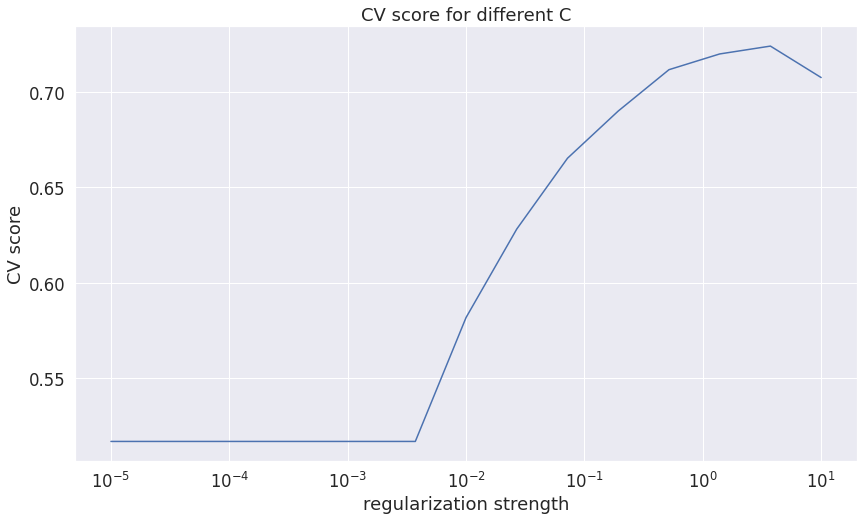

In [113]:
C_reg = np.logspace(-5, 1, 15)
lr = LogisticRegression()
searcher = GridSearchCV(lr, [{"C": C_reg}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_C = searcher.best_params_["C"]
print('Best regularization parameter:', best_C)

plt.figure(figsize=(14, 8))
plt.plot(C_reg, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("regularization strength")
plt.ylabel("CV score")
plt.title("CV score for different C")

Best solver: saga


Text(0.5, 1.0, 'CV score for different solvers')

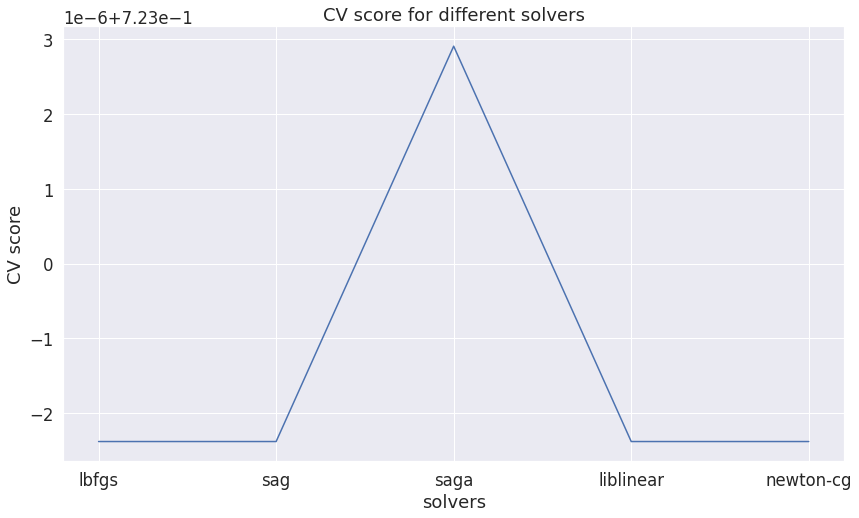

In [114]:
solvers = ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg']
lr = LogisticRegression()
searcher = GridSearchCV(lr, [{"solver": solvers}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_solver = searcher.best_params_["solver"]
print('Best solver:', best_solver)

plt.figure(figsize=(14, 8))
plt.plot(solvers, searcher.cv_results_["mean_test_score"])
#plt.xscale("log")
plt.xlabel("solvers")
plt.ylabel("CV score")
plt.title("CV score for different solvers")

In [115]:
lr = LogisticRegression()
lr.fit(X = vec_train, y = train['Preference'])

y_pred_lr = lr.predict(vec_test)
print('Default LogisticRegression accuracy:', accuracy_score(y_pred_lr, test['Preference']))

Default LogisticRegression accuracy: 0.7435633367662204


In [118]:
best_lr = LogisticRegression(C=best_C, solver=best_solver)
best_lr.fit(X = vec_train, y = train['Preference'])

y_pred_best_lr = best_lr.predict(vec_test)
print('Optimized LogisticRegression accuracy:', accuracy_score(y_pred_best_lr, test['Preference']))

Optimized LogisticRegression accuracy: 0.7404737384140062


### 4.2.4 MultinomialNB

Best alpha: 3.727593720314938


Text(0.5, 1.0, 'CV score for different alphas')

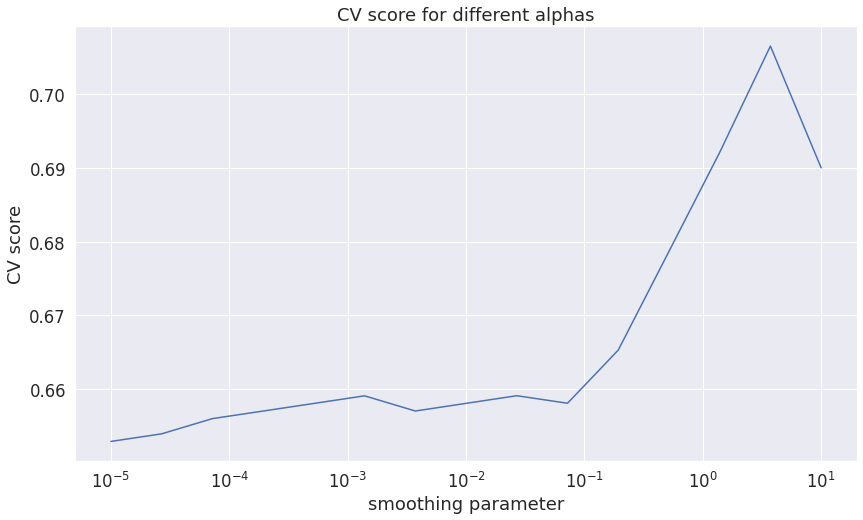

In [119]:
alphas = np.logspace(-5, 1, 15)
mnb = MultinomialNB()
searcher = GridSearchCV(mnb, [{"alpha": alphas}], scoring="accuracy", cv=5, n_jobs=-1)
searcher.fit(vec_test, test['Preference'])

best_alpha = searcher.best_params_["alpha"]
print('Best alpha:', best_alpha)

plt.figure(figsize=(14, 8))
plt.plot(alphas, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("smoothing parameter")
plt.ylabel("CV score")
plt.title("CV score for different alphas")

In [120]:
mnb = MultinomialNB()
mnb.fit(vec_train.toarray(), train['Preference'])

y_pred_mnb = mnb.predict(vec_test.toarray())
print('Default MultinomialNB accuracy:', accuracy_score(y_pred_mnb, test['Preference']))

Default MultinomialNB accuracy: 0.7312049433573635


In [121]:
best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(vec_train.toarray(), train['Preference'])

y_pred_best_mnb = best_mnb.predict(vec_test.toarray())
print('Optimized MultinomialNB accuracy:', accuracy_score(y_pred_best_mnb, test['Preference']))

Optimized MultinomialNB accuracy: 0.7404737384140062


### 4.2.5 AdaBoostClassifier

In [122]:
ac = AdaBoostClassifier(n_estimators = 100)
ac.fit(vec_train.toarray(), train['Preference'])

y_pred_ac = ac.predict(vec_test.toarray())
print('Default AdaBoostClassifier accuracy:', accuracy_score(y_pred_ac, test['Preference']))

Default AdaBoostClassifier accuracy: 0.6910401647785788


### 4.2.6 LightGBM

In [123]:
def objective(trial):
    # X_train, X_valid, y_train, y_valid = train_test_split(vec_train.toarray(), tra, test_size=0.25)
    X_train, X_valid, y_train, y_valid = vec_train.toarray(), vec_test.toarray(), train['Preference'], test['Preference']
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        'random_state' : 42,
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
    )

    preds = gbm.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy


study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
)
study.optimize(objective, n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-06-05 12:45:39,906] A new study created in memory with name: no-name-a2fbd0e6-956a-48e2-b7e6-9fd7829f6199
[I 2021-06-05 12:45:40,597] Trial 0 finished with value: 0.6601441812564367 and parameters: {'n_estimators': 188, 'max_depth': 15, 'learning_rate': 0.6123956346608946}. Best is trial 0 with value: 0.6601441812564367.
[I 2021-06-05 12:45:40,888] Trial 1 finished with value: 0.6652935118434603 and parameters: {'n_estimators': 156, 'max_depth': 6, 'learning_rate': 0.9462700069751558}. Best is trial 1 with value: 0.6652935118434603.
[I 2021-06-05 12:45:41,236] Trial 2 finished with value: 0.6642636457260556 and parameters: {'n_estimators': 73, 'max_depth': 32, 'learning_rate': 0.5849517952004}. Best is trial 1 with value: 0.6652935118434603.
[I 2021-06-05 12:45:41,759] Trial 3 finished with value: 0.6725025746652935 and parameters: {'n_estimators': 126, 'max_depth': 16, 'learning_rate': 0.21902206470894384}. Best is trial 3 with value: 0.6725025746652935.
[I 2021-06-05 12:45:42

Number of finished trials: 200
Best trial:
  Value: 0.7209062821833162
  Params: 
    n_estimators: 10
    max_depth: 6
    learning_rate: 0.29136907571049564


### 4.2.7 Сравнение результатов

In [124]:
predictions = [y_pred_dtc, y_pred_best_dtc, y_pred_rfc, y_pred_best_rfc, y_pred_lr, y_pred_best_lr, y_pred_mnb, y_pred_best_mnb, y_pred_ac]
accuracy_scores = [accuracy_score(pred, test['Preference']) for pred in predictions]
accuracy_scores.append(trial.value)

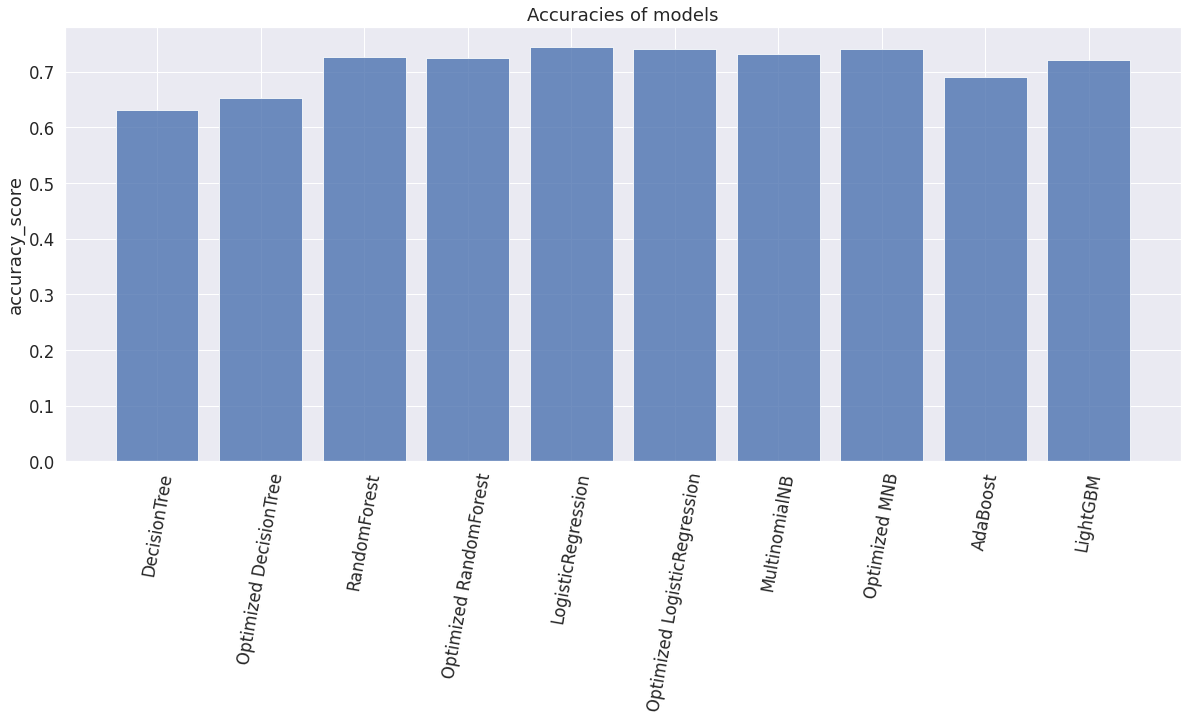

In [125]:
classifiers = ['DecisionTree', 'Optimized DecisionTree', 'RandomForest', 'Optimized RandomForest', 'LogisticRegression', 'Optimized LogisticRegression', 'MultinomialNB', 'Optimized MNB', 'AdaBoost', 'LightGBM']

Y_pos = np.arange(len(classifiers))
plt.figure(figsize=(20, 8))
plt.bar(Y_pos, accuracy_scores, align='center', alpha=0.8)
plt.xticks(Y_pos, classifiers, rotation=80)
plt.ylabel('accuracy_score')
plt.title('Accuracies of models')
plt.show()

In [126]:
print(max(accuracy_scores))

0.7435633367662204


## 4.3 Какая модель оказалась лучшей?
Лучшим оказалось сочетание CountVectorizer и логистической регрессии с подобранными гиперпараметрами

In [93]:
vec_train = cv.fit_transform(train['Tweet'].tolist())
vec_test = cv.transform(test['Tweet'].tolist())

best_lr = LogisticRegression(C=0.5179474679231213, solver='sag')
best_lr.fit(X = vec_train, y = train['Preference'])

LogisticRegression(C=0.5179474679231213, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

# 5. Непосредственно классификация
Возьмем нашу лучшую модель и применим ко всем твитам

In [94]:
classify_all_tweets = pd.read_csv("drive/MyDrive/colab/tweets.csv")
classify_all_tweets['Tweet'] = classify_all_tweets['Text']
classify_all_tweets.drop(columns=['Preference', 'Text'], inplace=True)
vec_all = cv.transform(classify_all_tweets['Tweet'].tolist())
y_all_lr = best_lr.predict(vec_all)
unique, counts = np.unique(y_all_lr, return_counts=True)
lr_res = dict(zip(unique, counts))
print('Number of Republican tweets: {}'.format(lr_res[0]))
print('Number of Democrat tweets: {}'.format(lr_res[1]))

Number of Republican tweets: 49683
Number of Democrat tweets: 46679
